In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
cd drive/MyDrive/COSE474_PCLIP/diffusion-point-cloud

[Errno 2] No such file or directory: 'drive/MyDrive/COSE474_PCLIP/diffusion-point-cloud'
/content/drive/MyDrive/COSE474_PCLIP/diffusion-point-cloud


In [49]:
# !git clone https://github.com/luost26/diffusion-point-cloud.git

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import argparse
import torch
from tqdm.auto import tqdm
from PIL import Image

In [51]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bln0nqbw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-bln0nqbw
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=13bc46903496faed1f4628850c64f8216ae1eb3a226090045b5f81593cc74f31
  Stored in directory: /tmp/pip-ephem-wheel-cache-ryh_lgqy/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [52]:
import clip
from utils.dataset import *
from utils.misc import *
from utils.data import *
from models.pclip_PEncoder import * ## 수정 : autoencoder가 아닌 CLIP을 위한 Point Cloud Encoder 사용
from evaluation import EMD_CD

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 74.1MiB/s]


In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load("ViT-B/32", device=device)

In [54]:
synsetid_to_cate = {
    '02691156': 'airplane', '02773838': 'bag', '02801938': 'basket',
    '02808440': 'bathtub', '02818832': 'bed', '02828884': 'bench',
    '02876657': 'bottle', '02880940': 'bowl', '02924116': 'bus',
    '02933112': 'cabinet', '02747177': 'can', '02942699': 'camera',
    '02954340': 'cap', '02958343': 'car', '03001627': 'chair',
    '03046257': 'clock', '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table', '04401088': 'telephone', '02946921': 'tin_can',
    '04460130': 'tower', '04468005': 'train', '03085013': 'keyboard',
    '03261776': 'earphone', '03325088': 'faucet', '03337140': 'file',
    '03467517': 'guitar', '03513137': 'helmet', '03593526': 'jar',
    '03624134': 'knife', '03636649': 'lamp', '03642806': 'laptop',
    '03691459': 'speaker', '03710193': 'mailbox', '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano', '03938244': 'pillow', '03948459': 'pistol',
    '03991062': 'pot', '04004475': 'printer', '04074963': 'remote_control',
    '04090263': 'rifle', '04099429': 'rocket', '04225987': 'skateboard',
    '04256520': 'sofa', '04330267': 'stove', '04530566': 'vessel',
    '04554684': 'washer', '02992529': 'cellphone',
    '02843684': 'birdhouse', '02871439': 'bookshelf',
    # '02858304': 'boat', no boat in our dataset, merged into vessels
    # '02834778': 'bicycle', not in our taxonomy
}
label_list = [v for _, v in synsetid_to_cate.items()]

In [55]:
import plotly.graph_objs as go

# 출처 : 포인트 클라우드 처리를 위한 open3d 사용법 정리 https://gaussian37.github.io/autodrive-lidar-open3d/

def show_point_cloud(points, color_axis=0, width_size=500, height_size=300, coordinate_frame=True):
    '''
    points : (N, 3) size of ndarray
    color_axis : 0, 1, 2
    '''
    assert points.shape[1] == 3
    assert color_axis==0 or color_axis==1 or color_axis==2


    # Create a scatter3d Plotly plot
    plotly_fig = go.Figure(data=[go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(
            size=3, ## 여기서 point 크기 조정 가능
            color=points[:, color_axis], # Set color based on Z-values
            colorscale='jet', # Choose a color scale
            colorbar=dict(title='value') # Add a color bar with a title
        )
    )])

    x_range = points[:, 0].max()*0.9 - points[:, 0].min()*0.9
    y_range = points[:, 1].max()*0.9 - points[:, 1].min()*0.9
    z_range = points[:, 2].max()*0.9 - points[:, 2].min()*0.9

    # Adjust the Z-axis scale
    plotly_fig.update_layout(
        scene=dict(
            aspectmode='manual',
            aspectratio=dict(x=x_range, y=y_range, z=z_range), # Here you can set the scale of the Z-axis
        ),
        width=width_size, # Width of the figure in pixels
        height=height_size, # Height of the figure in pixels
        showlegend=False
    )

    if coordinate_frame:
        # Length of the axes
        axis_length = 1

        # Create lines for the axes
        lines = [
            go.Scatter3d(x=[0, axis_length], y=[0, 0], z=[0, 0], mode='lines', line=dict(color='red')),
            go.Scatter3d(x=[0, 0], y=[0, axis_length], z=[0, 0], mode='lines', line=dict(color='green')),
            go.Scatter3d(x=[0, 0], y=[0, 0], z=[0, axis_length], mode='lines', line=dict(color='blue'))
        ]

        # Create cones (arrows) for the axes
        cones = [
            go.Cone(x=[axis_length], y=[0], z=[0], u=[axis_length], v=[0], w=[0], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False),
            go.Cone(x=[0], y=[axis_length], z=[0], u=[0], v=[axis_length], w=[0], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False),
            go.Cone(x=[0], y=[0], z=[axis_length], u=[0], v=[0], w=[axis_length], sizemode='absolute', sizeref=0.1, anchor='tail', showscale=False)
        ]

        # Add lines and cones to the figure
        for line in lines:
            plotly_fig.add_trace(line)
        for cone in cones:
            plotly_fig.add_trace(cone)

    # Show the plot
    plotly_fig.show()

In [56]:
# # Arguments
# parser = argparse.ArgumentParser()
# parser.add_argument('--ckpt', type=str, default='./logs_PCLIP/pclip_PEncoder/ckpt_0.000000_5000.pt')
# parser.add_argument('--categories', type=str_list, default=['all'])
# parser.add_argument('--save_dir', type=str, default='./results')
# parser.add_argument('--device', type=str, default='cuda')
# # Datasets and loaders
# parser.add_argument('--dataset_path', type=str, default='./data/shapenet.hdf5')
# parser.add_argument('--batch_size', type=int, default=128)
# args = parser.parse_args()

import easydict
args = easydict.EasyDict({
    "ckpt" : './logs_PCLIP/pclip_PEncoder/ckpt_0.000000_5000.pt',
    "categories" : ["all"],
    "save_dir" : './results',
    "device" : "cuda",
    "dataset_path" : './data/shapenet.hdf5',
    "batch_size" : 128

})

In [57]:
# Logging
save_dir = os.path.join(args.save_dir, 'pclip_PEncoder_%s_%d' % ('_'.join(args.categories), int(time.time())) )
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
logger = get_logger('test', save_dir)
for k, v in vars(args).items():
    logger.info('[ARGS::%s] %s' % (k, repr(v)))

# Checkpoint
ckpt = torch.load(args.ckpt)
seed_all(ckpt['args'].seed)

[2023-12-09 13:47:37,963::test::INFO] [ARGS::ckpt] './logs_PCLIP/pclip_PEncoder/ckpt_0.000000_5000.pt'
INFO:test:[ARGS::ckpt] './logs_PCLIP/pclip_PEncoder/ckpt_0.000000_5000.pt'
[2023-12-09 13:47:37,968::test::INFO] [ARGS::categories] ['all']
INFO:test:[ARGS::categories] ['all']
[2023-12-09 13:47:37,974::test::INFO] [ARGS::save_dir] './results'
INFO:test:[ARGS::save_dir] './results'
[2023-12-09 13:47:37,980::test::INFO] [ARGS::device] 'cuda'
INFO:test:[ARGS::device] 'cuda'
[2023-12-09 13:47:37,985::test::INFO] [ARGS::dataset_path] './data/shapenet.hdf5'
INFO:test:[ARGS::dataset_path] './data/shapenet.hdf5'
[2023-12-09 13:47:37,989::test::INFO] [ARGS::batch_size] 128
INFO:test:[ARGS::batch_size] 128


In [58]:
# Datasets and loaders
test_dset = ShapeNetCore(
    path=args.dataset_path,
    cates=args.categories,
    split='test',
    scale_mode=ckpt['args'].scale_mode
)
test_loader = DataLoader(test_dset, batch_size=args.batch_size, num_workers=0)

In [59]:
model = PCLIP_PEncoder(ckpt['args']).to(args.device)
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [60]:
test_loss = []
for i, batch in enumerate(tqdm(test_loader)):
    point = batch['pointcloud'].to(args.device) # shape : torch.Size([32, 2048, 3])
    cate = batch['cate'] ## 수정 : category 정보를 함께 이용

    model.eval()
    with torch.no_grad():
        code_point = model.encode(point)
        text = clip.tokenize(cate).to(device)
        code_text = model_clip.encode_text(text)
        lossfn = torch.nn.MSELoss()
        loss = lossfn(code_point, code_text)  # input, target
        test_loss.append(loss.detach().cpu())
test_loss = np.array(test_loss)

  0%|          | 0/61 [00:00<?, ?it/s]

In [65]:
test_loss

array([0.0266605 , 0.02350692, 0.02608576, 0.02630958, 0.02735432,
       0.02711854, 0.02558868, 0.02571788, 0.02685582, 0.02483783,
       0.02656277, 0.02695585, 0.02635108, 0.02599853, 0.02857745,
       0.03004085, 0.02463979, 0.02633987, 0.025767  , 0.02764867,
       0.02652309, 0.02924613, 0.02672224, 0.02691153, 0.02474657,
       0.02664066, 0.02346993, 0.02595391, 0.02543871, 0.02755249,
       0.02536759, 0.02637919, 0.0241162 , 0.02520298, 0.02567233,
       0.02457268, 0.0267969 , 0.02563598, 0.02735072, 0.02937942,
       0.02640518, 0.02698241, 0.02600889, 0.02669912, 0.02544409,
       0.02725795, 0.02598309, 0.02642378, 0.02467583, 0.02730778,
       0.02709908, 0.02525292, 0.02588372, 0.02595337, 0.02782821,
       0.02651282, 0.02726128, 0.02415186, 0.02627241, 0.0250607 ,
       0.03157465], dtype=float32)

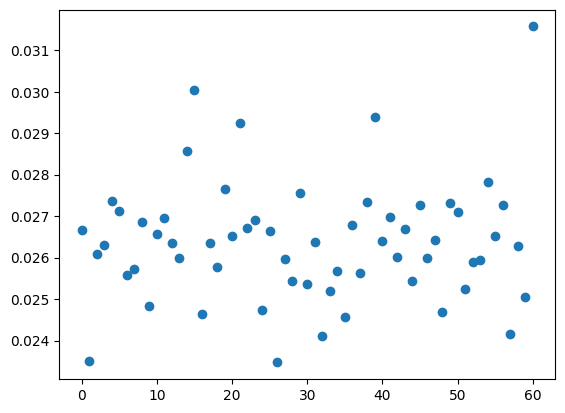

In [66]:
plt.scatter(range(len(test_loss)), test_loss)

In [61]:
np.mean(np.array(test_loss))

0.02637108

# Qualitative Results

In [66]:
dispcate = ['table','chair','car','cap','camera','can','cabinet','bus','bowl','bottle','bench','bed','bathtub','basket','bag','airplane']
leftcate = dispcate

In [ ]:
i = 0
while len(leftcate):
  sample = test_dset.__getitem__(i)
  if sample['cate'] in dispcate:
    print("start cate", sample['cate'])
    # point = sample['pointcloud']
    cate = sample['cate']

    # point = point[None,:,:]


    # point = point.to(args.device)
    image = preprocess(Image.open("./images/"+cate+".jpg")).unsqueeze(0).to(device)
    text = clip.tokenize(['table','dog','cat']).to(device) # 여기 수정 필요

    # model.eval()
    with torch.no_grad():
      image_features = model_clip.encode_image(image)
      text_features = model_clip.encode_text(text)

      logits_per_image, logits_per_text = model_clip(image_features, text_features)
      probs = logits_per_image.softmax(dim=-1).cpu().numpy()

      print("Category :", cate)
      show_point_cloud(torch.Tensor.numpy(point))
      dispcate.remove(sample['cate'])
      print("Label probs:", probs)

  i += 1

In [46]:
test_loss = []
for i, batch in enumerate(tqdm(test_loader)):
    point = batch['pointcloud'].to(args.device) # shape : torch.Size([32, 2048, 3])
    cate = batch['cate'] ## 수정 : category 정보를 함께 이용

    model.eval()
    with torch.no_grad():
        code_point = model.encode(point)
        text = clip.tokenize(cate).to(device)

        code_text = model_clip.encode_text(text)

        print(code_text.shape)
        print(code_point.shape)


        lossfn = torch.nn.MSELoss()
        loss = lossfn(code_point, code_text)  # input, target
        test_loss.append(loss.detach().cpu())
test_loss = np.array(test_loss)

NameError: ignored

In [136]:
test_loss

array([0.0266605 , 0.02350692, 0.02608576, 0.02630958, 0.02735432,
       0.02711854, 0.02558868, 0.02571788, 0.02685582, 0.02483783,
       0.02656277, 0.02695585, 0.02635108, 0.02599853, 0.02857745,
       0.03004085, 0.02463979, 0.02633987, 0.025767  , 0.02764867,
       0.02652309, 0.02924613, 0.02672224, 0.02691153, 0.02474657,
       0.02664066, 0.02346993, 0.02595391, 0.02543871, 0.02755249,
       0.02536759, 0.02637919, 0.0241162 , 0.02520298, 0.02567233,
       0.02457268, 0.0267969 , 0.02563598, 0.02735072, 0.02937942,
       0.02640518, 0.02698241, 0.02600889, 0.02669912, 0.02544409,
       0.02725795, 0.02598309, 0.02642378, 0.02467583, 0.02730778,
       0.02709908, 0.02525292, 0.02588372, 0.02595337, 0.02782821,
       0.02651282, 0.02726128, 0.02415186, 0.02627241, 0.0250607 ,
       0.03157465], dtype=float32)

In [142]:
sample = test_dset.__getitem__(1)
cate = sample['cate']
point = sample['pointcloud'].to(args.device)
point = point[None,:,:]

image = preprocess(Image.open("./images/"+cate+".jpg")).unsqueeze(0).to(device)
text = clip.tokenize(dispcate).to(device)

print(text.shape)
print(point.shape)

model.eval()
with torch.no_grad():

    point_features = model.encode(point)

    print(point_features.shape)
    image_features = model_clip.encode_image(image)
    text_features = model_clip.encode_text(text)

    print("여기~~", text_features.shape)

    logits_per_image, logits_per_text = model_clip(image, text)

    # logits_per_image, logits_per_text = model_clip(image, text)


    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

torch.Size([16, 77])
torch.Size([1, 2048, 3])
torch.Size([1, 512])
여기~~ torch.Size([16, 512])
Label probs: [[9.775e-01 3.527e-03 2.956e-05 1.326e-04 4.470e-06 1.729e-04 4.059e-03
  2.503e-06 9.198e-04 5.066e-06 1.310e-02 1.433e-04 3.797e-05 9.108e-05
  5.066e-06 6.378e-06]]


In [133]:
dispcate

['table',
 'chair',
 'car',
 'cap',
 'camera',
 'can',
 'cabinet',
 'bus',
 'bowl',
 'bottle',
 'bench',
 'bed',
 'bathtub',
 'basket',
 'bag',
 'airplane']

In [29]:
log = open("./logs_PCLIP/pclip_PEncoder/log.txt","r")

In [14]:
example = "[2023-12-09 07:28:27,299::train::INFO] [Train] Iter 0001 | Loss 6.925140 | Grad 9.8979"

In [22]:
example[64:72]

'6.925140'

In [24]:
example[80:85]

'9.897'

''

In [30]:
train_loss = []
train_grad = []

status = False
while True:
  line = log.readline()
  print(line)
  if status == True:
    train_loss.append(float(line[64:72]))
    train_grad.append(float(line[80:85]))
  if "Start training..." in line:
    status = True

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

[2023-12-09 07:32:27,810::train::INFO] [Train] Iter 2502 | Loss 0.027196 | Grad 0.0399 

[2023-12-09 07:32:27,900::train::INFO] [Train] Iter 2503 | Loss 0.027810 | Grad 0.0356 

[2023-12-09 07:32:27,992::train::INFO] [Train] Iter 2504 | Loss 0.029959 | Grad 0.0552 

[2023-12-09 07:32:28,083::train::INFO] [Train] Iter 2505 | Loss 0.029482 | Grad 0.0448 

[2023-12-09 07:32:28,174::train::INFO] [Train] Iter 2506 | Loss 0.029651 | Grad 0.0486 

[2023-12-09 07:32:28,264::train::INFO] [Train] Iter 2507 | Loss 0.028037 | Grad 0.0247 

[2023-12-09 07:32:28,355::train::INFO] [Train] Iter 2508 | Loss 0.029363 | Grad 0.0372 

[2023-12-09 07:32:28,445::train::INFO] [Train] Iter 2509 | Loss 0.030234 | Grad 0.0420 

[2023-12-09 07:32:28,535::train::INFO] [Train] Iter 2510 | Loss 0.027673 | Grad 0.0563 

[2023-12-09 07:32:28,626::train::INFO] [Train] Iter 2511 | Loss 0.030233 | Grad 0.0316 

[2023-12-09 07:32:28,715::train::INFO] [Train] Iter 2512 | Loss 0.030084 

ValueError: ignored

In [33]:
len(train_loss)

5000

In [34]:
len(train_grad)

5000

In [38]:
train_loss[:10]

[6.92514,
 5.010074,
 3.906588,
 3.238744,
 2.869688,
 2.543706,
 2.238871,
 2.048601,
 1.84001,
 1.737139]

In [39]:
train_grad[:10]

[9.897, 5.536, 4.025, 3.263, 2.881, 2.463, 2.14, 1.921, 1.729, 1.677]

In [35]:
import matplotlib.pyplot as plt

(0.0, 1000.0, 0.0, 1.0)

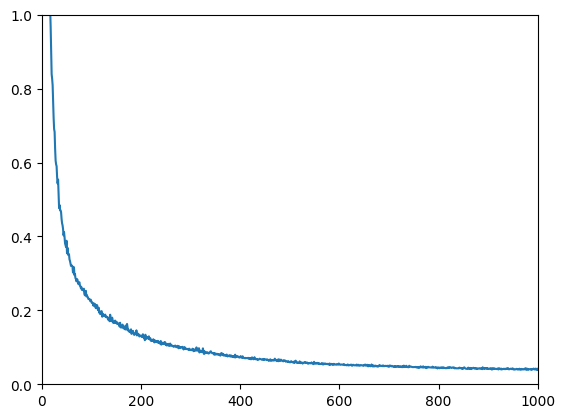

In [43]:
plt.plot(range(len(train_loss)),train_loss)
plt.axis([0, 1000, 0, 1])

(0.0, 1000.0, 0.0, 1.0)

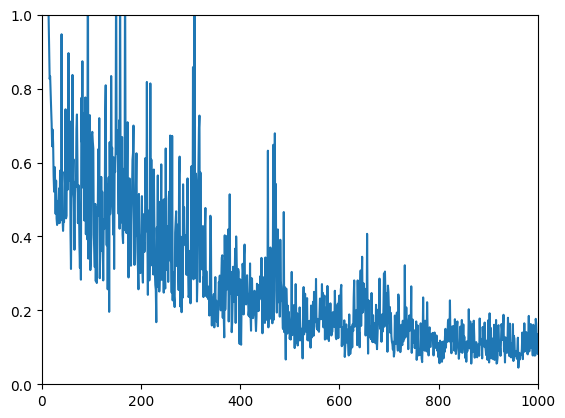

In [45]:
plt.plot(range(len(train_grad)),train_grad)
plt.axis([0, 1000, 0, 1])